Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

### Understand the Data

In [2]:
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

print(df.info())
print("----------------------------------------------")

print(df.describe())
print("----------------------------------------------")

print(df.isnull().sum())
print("----------------------------------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None
-----------------

### Transform our Data

We need to replace NaN values with "None", to represent no sleeping disorder.

In [3]:
df = df.copy()

df["Sleep Disorder"] = df["Sleep Disorder"].fillna("None")

df['Sleep Disorder']

0             None
1             None
2             None
3      Sleep Apnea
4      Sleep Apnea
          ...     
369    Sleep Apnea
370    Sleep Apnea
371    Sleep Apnea
372    Sleep Apnea
373    Sleep Apnea
Name: Sleep Disorder, Length: 374, dtype: object

Transform Object labels to numerical values
- 0: Doesn't have sleep disorder
- 1: Has sleep disorder

In [4]:
print(df['Sleep Disorder'].isna().sum())

# Create Binary Label
df["target"] = df["Sleep Disorder"].apply(
    lambda x: 0 if str(x).strip().lower() in ["none"] else 1
).astype(int)

0


In [5]:
# Check
print(df.columns)
print(df['target'][:5])

Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps',
       'Sleep Disorder', 'target'],
      dtype='object')
0    0
1    0
2    0
3    1
4    1
Name: target, dtype: int64


#### Preprocessing: Transform Categorical Values to Numerical 

In [6]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,target
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None,0
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,0
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,0
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,1
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,1


#### BMI Category Encoding
- Standardize category names
- One-hot encoding with drop_first=True
- Results in: BMI_Obese, BMI_Overweight (Normal is reference category)

In [7]:
print(df["BMI Category"].unique())

df["BMI Category"] = df["BMI Category"].replace({
    "Normal Weight": "Normal"
})

print(df["BMI Category"].unique())

# One hot encoding
bmi_encoded = pd.get_dummies(df["BMI Category"], prefix="BMI", drop_first=True).astype(int)
df = pd.concat([df, bmi_encoded], axis=1)
df = df.drop(columns=["BMI Category"])

df.columns

['Overweight' 'Normal' 'Obese' 'Normal Weight']
['Overweight' 'Normal' 'Obese']


Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder',
       'target', 'BMI_Obese', 'BMI_Overweight'],
      dtype='object')

#### Gender Encoding
Results in Gender_Male (Female is reference category)

In [8]:
print(df['Gender'].unique())

gender_encoded = pd.get_dummies(df["Gender"], prefix="Gender", drop_first=True).astype(int)
df = pd.concat([df, gender_encoded], axis=1)
print(df.columns)
df.head(5)

['Male' 'Female']
Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder',
       'target', 'BMI_Obese', 'BMI_Overweight', 'Gender_Male'],
      dtype='object')


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,target,BMI_Obese,BMI_Overweight,Gender_Male
0,1,Male,27,Software Engineer,6.1,6,42,6,126/83,77,4200,None,0,0,1,1
1,2,Male,28,Doctor,6.2,6,60,8,125/80,75,10000,None,0,0,0,1
2,3,Male,28,Doctor,6.2,6,60,8,125/80,75,10000,None,0,0,0,1
3,4,Male,28,Sales Representative,5.9,4,30,8,140/90,85,3000,Sleep Apnea,1,1,0,1
4,5,Male,28,Sales Representative,5.9,4,30,8,140/90,85,3000,Sleep Apnea,1,1,0,1


#### Blood Pressure Feature Engineering
Blood pressure string (e.g., "120/80") decomposed into multiple informative features:

**Numeric Components:**
- **BP_Systolic** = extracted from "120/80" → 120
- **BP_Diastolic** = extracted from "120/80" → 80
- **Pulse_Pressure** = Systolic - Diastolic
- **Mean Arterial Pressure** = Diastolic + (Pulse_Pressure / 3.0)

**Clinical Category Flags (Mutually Exclusive):**
- **BP_Normal**: Systolic < 120 AND Diastolic < 80
- **BP_Elevated**: Systolic 120-129 AND Diastolic < 80
- **BP_HTN1**: Systolic 130-139 OR Diastolic 80-89 (Stage 1 Hypertension)
- **BP_HTN2**: Systolic ≥ 140 OR Diastolic ≥ 90 (Stage 2 Hypertension)
- **BP_Crisis**: Systolic ≥ 180 OR Diastolic ≥ 120 (Hypertensive Crisis)

In [9]:
# 1) Parse "120/80" -> floats
bp = df["Blood Pressure"].astype(str).str.strip()
bp_sys = pd.to_numeric(bp.str.split("/", expand=True)[0], errors="coerce")
bp_dia = pd.to_numeric(bp.str.split("/", expand=True)[1], errors="coerce")

df["BP_Systolic"]  = bp_sys
df["BP_Diastolic"] = bp_dia

# 2) Category flags (0/1)
norm   = (df["BP_Systolic"] < 120) & (df["BP_Diastolic"] < 80)
elev   = (df["BP_Systolic"].between(120, 129)) & (df["BP_Diastolic"] < 80)
htn1   = (df["BP_Systolic"].between(130, 139)) | (df["BP_Diastolic"].between(80, 89))
htn2   = (df["BP_Systolic"] >= 140) | (df["BP_Diastolic"] >= 90)
crisis = (df["BP_Systolic"] >= 180) | (df["BP_Diastolic"] >= 120)

df["BP_Normal"]   = norm.astype(int)
df["BP_Elevated"] = (~norm & elev).astype(int)        # ensure mutually exclusive
df["BP_HTN1"]     = (~norm & ~elev & htn1).astype(int)
df["BP_HTN2"]     = (~norm & ~elev & ~htn1 & htn2).astype(int)
df["BP_Crisis"]   = crisis.astype(int)

# 3) (Optional) extra numeric signals
df["Pulse_Pressure"] = df["BP_Systolic"] - df["BP_Diastolic"]   # often informative
df["MAP"] = df["BP_Diastolic"] + (df["Pulse_Pressure"] / 3.0)   # mean arterial pressure

In [10]:
df.columns

Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder',
       'target', 'BMI_Obese', 'BMI_Overweight', 'Gender_Male', 'BP_Systolic',
       'BP_Diastolic', 'BP_Normal', 'BP_Elevated', 'BP_HTN1', 'BP_HTN2',
       'BP_Crisis', 'Pulse_Pressure', 'MAP'],
      dtype='object')

#### Occupation Encoding
- One-hot encoding for all occupation categories
- Creates binary indicators for: Doctor, Engineer, Nurse, etc.

In [11]:
occ_encoded = pd.get_dummies(df["Occupation"], prefix="Occ", drop_first=False, dtype=int)
df = pd.concat([df, occ_encoded], axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Person ID                 374 non-null    int64  
 1   Gender                    374 non-null    object 
 2   Age                       374 non-null    int64  
 3   Occupation                374 non-null    object 
 4   Sleep Duration            374 non-null    float64
 5   Quality of Sleep          374 non-null    int64  
 6   Physical Activity Level   374 non-null    int64  
 7   Stress Level              374 non-null    int64  
 8   Blood Pressure            374 non-null    object 
 9   Heart Rate                374 non-null    int64  
 10  Daily Steps               374 non-null    int64  
 11  Sleep Disorder            374 non-null    object 
 12  target                    374 non-null    int64  
 13  BMI_Obese                 374 non-null    int64  
 14  BMI_Overwe

### Correlation Analysis

In [13]:
# Lets see correlation to get a feeling of valuable features
import numpy as np
import pandas as pd

# keep only numeric columns (drop text columns like Gender, Occupation, Blood Pressure, Sleep Disorder)
num_cols = df.select_dtypes(include=[np.number]).columns

# correlation of every numeric feature with the binary target
corr_with_target = (
    df[num_cols]
    .corr(numeric_only=True)['target']     # correlation vector vs target
    .drop('target')                        # remove self-correlation
    .sort_values(ascending=False)
)

print("Correlation with target (descending):\n")
print(corr_with_target)

# If you want the top N:
print("\nTop 10 features by |correlation|:\n")
print(corr_with_target.abs().sort_values(ascending=False).head(10))

Correlation with target (descending):

BMI_Overweight              0.751018
BP_Diastolic                0.705025
MAP                         0.704726
BP_Systolic                 0.692480
BP_HTN2                     0.506193
Occ_Nurse                   0.462127
Pulse_Pressure              0.451987
Person ID                   0.446196
Age                         0.432007
Heart Rate                  0.330254
Occ_Salesperson             0.324787
Occ_Teacher                 0.253291
BMI_Obese                   0.197018
Stress Level                0.181685
Occ_Sales Representative    0.087156
Physical Activity Level     0.069787
Occ_Scientist               0.018059
Daily Steps                -0.026575
Occ_Software Engineer      -0.034707
Occ_Manager                -0.043560
BP_Elevated                -0.043560
Occ_Accountant             -0.151507
Occ_Lawyer                 -0.237076
BP_HTN1                    -0.250215
BP_Normal                  -0.260453
Gender_Male                -0.285824

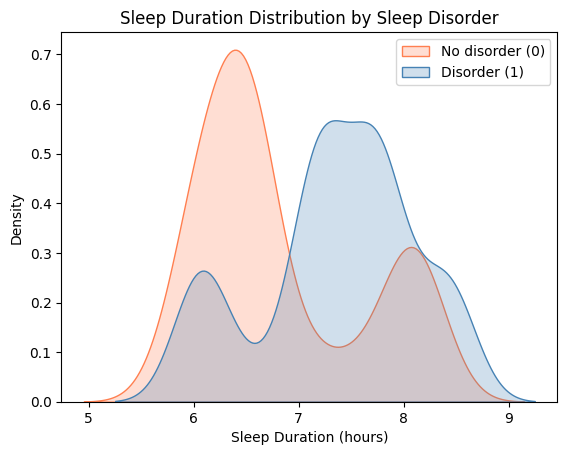

In [14]:
sns.kdeplot(data=df, x="Sleep Duration", hue="target", fill=True, common_norm=False,
            palette={0:"steelblue", 1:"coral"})
plt.title("Sleep Duration Distribution by Sleep Disorder")
plt.xlabel("Sleep Duration (hours)")
plt.ylabel("Density")
plt.legend(["No disorder (0)", "Disorder (1)"])
plt.show()

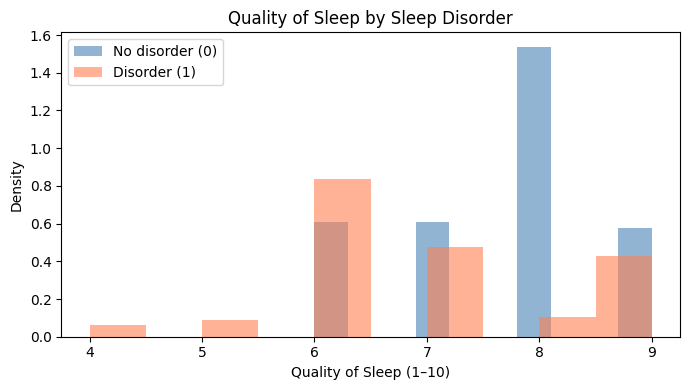

In [15]:
q0 = df.loc[df["target"]==0, "Quality of Sleep"].dropna()
q1 = df.loc[df["target"]==1, "Quality of Sleep"].dropna()

plt.figure(figsize=(7,4))
plt.hist(q0, bins=10, alpha=0.6, density=True, label="No disorder (0)", color="steelblue")
plt.hist(q1, bins=10, alpha=0.6, density=True, label="Disorder (1)", color="coral")
plt.xlabel("Quality of Sleep (1–10)")
plt.ylabel("Density")
plt.title("Quality of Sleep by Sleep Disorder")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
df.columns

Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder',
       'target', 'BMI_Obese', 'BMI_Overweight', 'Gender_Male', 'BP_Systolic',
       'BP_Diastolic', 'BP_Normal', 'BP_Elevated', 'BP_HTN1', 'BP_HTN2',
       'BP_Crisis', 'Pulse_Pressure', 'MAP', 'Occ_Accountant', 'Occ_Doctor',
       'Occ_Engineer', 'Occ_Lawyer', 'Occ_Manager', 'Occ_Nurse',
       'Occ_Sales Representative', 'Occ_Salesperson', 'Occ_Scientist',
       'Occ_Software Engineer', 'Occ_Teacher'],
      dtype='object')

We will need to exclude occupation categories with low representation


In [17]:
df["Occupation"].value_counts()

Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

### Feature Selection

In [18]:
dfm = df.copy()

drop_cols = [
    "Person ID",
    "Gender",
    "Occupation",
    "Blood Pressure",
    "Sleep Disorder",
    "BMI_Obsese",
    "Stress Level",
    "Occ_Sales",
    "Representative",
    "Physical Activity Level",
    "Occ_Scientist",
    "Daily Steps",
    "Occ_Software Engineer",
    "Occ_Scientist",
    "Occ_Sales Representative",
    "Occ_Manager",
    "BP_Elevated",
    "Occ_Accountant",
    "Occ_Lawyer",
    "BP_Crises",
    "MAP"
]

cols = ['Age','Sleep Duration','Quality of Sleep','Heart Rate','target',
        'BMI_Obese','BMI_Overweight','Gender_Male','BP_Systolic','BP_Diastolic',
        'BP_Normal','BP_HTN1','BP_HTN2','BP_Crisis','Pulse_Pressure',
        'Occ_Doctor','Occ_Engineer','Occ_Nurse','Occ_Salesperson','Occ_Teacher']

dfm = df[cols].copy()

y = dfm['target'].astype(int).values
X = dfm.drop(columns=['target']).copy()

# Continuous features to scale (leave 0/1 dummies unscaled)
cont_cols = ['Age','Sleep Duration','Quality of Sleep','Heart Rate',
             'BP_Systolic','BP_Diastolic','Pulse_Pressure']

# Binary dummies (0/1) – leave as-is
bin_cols = [c for c in X.columns if c not in cont_cols]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Z-score normalization using TRAINING set statistics only

In [19]:
# z-score on train stats
mu = X_train[cont_cols].mean()
sd = X_train[cont_cols].std().replace(0, 1)

X_train_s = X_train.copy()
X_test_s  = X_test.copy()
X_train_s[cont_cols] = (X_train[cont_cols] - mu) / sd
X_test_s[cont_cols]  = (X_test[cont_cols]  - mu) / sd

# Convert to float32 for Keras
Xtr = X_train_s.values.astype('float32')
Xte = X_test_s.values.astype('float32')
ytr = y_train.astype('float32')
yte = y_test.astype('float32')

print("Shapes:", Xtr.shape, Xte.shape)

Shapes: (299, 19) (75, 19)


### Neural Network Architecture
- **Smaller network** (32→16→1) suitable for dataset size
- **L2 Regularization**: 1e-5 to prevent overfitting
- **Dropout**: 10% rate for improved generalization
- **Activation**: ReLU for hidden layers, sigmoid for binary output
- **Loss**: Binary cross-entropy
- **Optimizer**: Adam with tunable learning rate
- **Metrics**: AUC (Area Under ROC Curve)

In [20]:
def build_model(input_dim, lr=1e-3, l2=1e-5, dropout=0.1):
    reg = keras.regularizers.l2(l2) if l2 else None
    m = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(32, activation="relu", kernel_regularizer=reg),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(16, activation="relu", kernel_regularizer=reg),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return m

# Class weights (helpful if imbalance)
pos = int((y_train==1).sum()); neg = int((y_train==0).sum()); tot = len(y_train)
class_weight = {0: tot/(2*neg), 1: tot/(2*pos)}
print("Class weights:", class_weight)

Class weights: {0: 0.8542857142857143, 1: 1.2056451612903225}


#### Grid Search Configuration
Systematic exploration of hyperparameter space:
- **Learning Rates**: [2e-4, 5e-4, 1e-3, 2e-3]
- **Batch Sizes**: [8, 16, 32, 64]
- **Epochs**: 200 (with early stopping)
- **Early Stopping**: Patience=10, monitoring val_loss

Each learning rate × batch size combination evaluated:
- Total configurations tested: 4 × 4 = 16
- Selection criterion: Maximum F1 score
- Validation split: 20% of training data

In [21]:
tf.keras.utils.set_random_seed(42)

lrs = [2e-4, 5e-4, 1e-3, 2e-3]
bss = [8, 16, 32, 64]
pat = 10

results = []
for lr in lrs:
    for bs in bss:
        model = build_model(Xtr.shape[1], lr=lr, l2=1e-5, dropout=0.1)
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=pat, restore_best_weights=True)
        model.fit(
            Xtr, ytr, validation_split=0.2, epochs=200, batch_size=bs,
            callbacks=[es], class_weight=class_weight, verbose=0
        )
        p = model.predict(Xte, verbose=0).ravel()
        yhat = (p >= 0.5).astype(int)

        acc = accuracy_score(yte, yhat)
        auc = roc_auc_score(yte, p)
        f1  = f1_score(yte, yhat)

        results.append((lr, bs, acc, auc, f1))
        print(f"LR={lr:<6} | BS={bs:<3} | Acc={acc:.3f}  AUC={auc:.3f}  F1={f1:.3f}")

# Best by F1 (change index 4→3 to pick by AUC)
best = max(results, key=lambda x: x[4])
print("\nBest combo (by F1): LR=%.0e, Batch=%d | Acc=%.3f  AUC=%.3f  F1=%.3f"
      % (best[0], best[1], best[2], best[3], best[4]))

LR=0.0002 | BS=8   | Acc=0.893  AUC=0.959  F1=0.879
LR=0.0002 | BS=16  | Acc=0.907  AUC=0.957  F1=0.892
LR=0.0002 | BS=32  | Acc=0.907  AUC=0.966  F1=0.892
LR=0.0002 | BS=64  | Acc=0.893  AUC=0.961  F1=0.879
LR=0.0005 | BS=8   | Acc=0.907  AUC=0.960  F1=0.892
LR=0.0005 | BS=16  | Acc=0.893  AUC=0.967  F1=0.879
LR=0.0005 | BS=32  | Acc=0.907  AUC=0.974  F1=0.892
LR=0.0005 | BS=64  | Acc=0.907  AUC=0.966  F1=0.892
LR=0.001  | BS=8   | Acc=0.893  AUC=0.965  F1=0.879
LR=0.001  | BS=16  | Acc=0.920  AUC=0.964  F1=0.906
LR=0.001  | BS=32  | Acc=0.893  AUC=0.965  F1=0.879
LR=0.001  | BS=64  | Acc=0.920  AUC=0.963  F1=0.906
LR=0.002  | BS=8   | Acc=0.893  AUC=0.967  F1=0.879
LR=0.002  | BS=16  | Acc=0.893  AUC=0.957  F1=0.879
LR=0.002  | BS=32  | Acc=0.907  AUC=0.965  F1=0.892
LR=0.002  | BS=64  | Acc=0.907  AUC=0.969  F1=0.892

Best combo (by F1): LR=1e-03, Batch=16 | Acc=0.920  AUC=0.964  F1=0.906


**Best Hyperparameters Found:**
- **Learning Rate**: 1e-3
- **Batch Size**: 16

### Final Refit + Evaluation (best settings)

In [22]:
best_lr = 1e-3
best_bs = 16

final_model = build_model(Xtr.shape[1], lr=best_lr, l2=1e-5, dropout=0.1)

# Early stopping ensures the model stops when validation loss stops improving
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# --- Refit using the full training set (with val split) ---
history = final_model.fit(
    Xtr, ytr,
    validation_split=0.2,
    epochs=200,
    batch_size=best_bs,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)

# --- Evaluate on the test set ---
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix

# Predict probabilities & classes
pred_probs = final_model.predict(Xte, verbose=0).ravel()
y_pred = (pred_probs >= 0.5).astype(int)

# Compute metrics
acc = accuracy_score(yte, y_pred)
auc = roc_auc_score(yte, pred_probs)
f1 = f1_score(yte, y_pred)

print(f"\nFinal Test Results | Acc={acc:.3f}  AUC={auc:.3f}  F1={f1:.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(yte, y_pred))
print("\nClassification Report:\n", classification_report(yte, y_pred, digits=3))

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7441 - loss: 0.6624 - val_auc: 0.8825 - val_loss: 0.5283
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9104 - loss: 0.5696 - val_auc: 0.8986 - val_loss: 0.4866
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9456 - loss: 0.4992 - val_auc: 0.9005 - val_loss: 0.4487
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9428 - loss: 0.4494 - val_auc: 0.8973 - val_loss: 0.4149
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9523 - loss: 0.3935 - val_auc: 0.9069 - val_loss: 0.3829
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9516 - loss: 0.3558 - val_auc: 0.9095 - val_loss: 0.3564
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9457 - loss: 0.3182 - val_auc: 0.9063 - val_loss: 0.3377
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9474 - loss: 0.2918 - val_auc: 0.9063 - val_loss: 0.3231
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.949

In [23]:
best_epoch = int(np.argmin(history.history["val_loss"])) + 1
print("Best epoch (by val_loss):", best_epoch)
print("Val AUC at best epoch:", history.history["val_auc"][best_epoch-1])

Best epoch (by val_loss): 14
Val AUC at best epoch: 0.9056482315063477


### Cross-Validation Analysis

Configuration
- 5 folds with shuffle
- Stratification maintains target distribution in each fold
- Same architecture and hyperparameters across folds

In [24]:
cont_cols = ['Age','Sleep Duration','Quality of Sleep','Heart Rate',
             'BP_Systolic','BP_Diastolic','Pulse_Pressure']

y_np = np.asarray(y, dtype=np.float32)
X_cols = X.columns.tolist()

def build_model(input_dim, lr=1e-3, l2=1e-5, dropout=0.1):
    reg = keras.regularizers.l2(l2) if l2 else None
    m = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(32, activation="relu", kernel_regularizer=reg),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(16, activation="relu", kernel_regularizer=reg),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return m

# K-fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, aucs, f1s = [], [], []

fold = 0
for tr_idx, te_idx in kf.split(X, y_np):
    fold += 1

    X_tr_df = X.iloc[tr_idx].copy()
    X_te_df = X.iloc[te_idx].copy()
    y_tr = y_np[tr_idx]
    y_te = y_np[te_idx]

    # scale continuous columns using *train fold* stats only
    mu = X_tr_df[cont_cols].mean()
    sd = X_tr_df[cont_cols].std().replace(0, 1)
    X_tr_df[cont_cols] = (X_tr_df[cont_cols] - mu) / sd
    X_te_df[cont_cols] = (X_te_df[cont_cols] - mu) / sd

    # to float32 arrays
    X_tr = X_tr_df.values.astype("float32")
    X_te = X_te_df.values.astype("float32")

    # class weights per fold (handle imbalance)
    pos = int((y_tr == 1).sum())
    neg = int((y_tr == 0).sum())
    tot = len(y_tr)
    class_weight = {0: tot/(2*neg), 1: tot/(2*pos)}

    # build & train
    tf.keras.utils.set_random_seed(42)
    model = build_model(X_tr.shape[1], lr=1e-3, l2=1e-5, dropout=0.1)

    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    model.fit(
        X_tr, y_tr,
        validation_split=0.2,
        epochs=200,
        batch_size=16,
        callbacks=[es],
        class_weight=class_weight,
        verbose=0
    )

    # evaluate on the held-out fold
    p = model.predict(X_te, verbose=0).ravel()
    yhat = (p >= 0.5).astype(int)

    acc = accuracy_score(y_te, yhat)
    auc = roc_auc_score(y_te, p)
    f1  = f1_score(y_te, yhat)

    accs.append(acc); aucs.append(auc); f1s.append(f1)
    print(f"Fold {fold}: Acc={acc:.3f}  AUC={auc:.3f}  F1={f1:.3f}")

# Summary
print("\n5-Fold CV Summary:")
print("Accuracy : %.3f ± %.3f" % (np.mean(accs), np.std(accs)))
print("ROC-AUC  : %.3f ± %.3f" % (np.mean(aucs), np.std(aucs)))
print("F1       : %.3f ± %.3f" % (np.mean(f1s), np.std(f1s)))

Fold 1: Acc=0.947  AUC=0.948  F1=0.931
Fold 2: Acc=0.947  AUC=0.947  F1=0.935
Fold 3: Acc=0.920  AUC=0.951  F1=0.903
Fold 4: Acc=0.947  AUC=0.951  F1=0.938
Fold 5: Acc=0.919  AUC=0.916  F1=0.906

5-Fold CV Summary:
Accuracy : 0.936 ± 0.013
ROC-AUC  : 0.943 ± 0.013
F1       : 0.923 ± 0.015


- Very consistent performance across folds
- Low standard deviations (±0.02) indicate the model has good stability and generalizability
- Model not overfitting to specific train-test splits.